<a href="https://colab.research.google.com/github/Hamza-333/Text-Summarizer/blob/main/413_Final_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

In [3]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 38.2 MB/s eta 0:00:00


In [4]:
from datasets import list_datasets, load_dataset

In [5]:
datasets = list_datasets()

In [6]:
# load cnn-daily mail
# cnn = load_dataset('cnn_dailymail', '1.0.0')

In [7]:
# cnn['train'][0]

In [8]:
# load multi news
# multi_news = load_dataset('multi_news')

In [9]:
# # load stacked sum
# stacked_sum = load_dataset('stacked-summaries/stacked-xsum')

In [10]:
# using around 114k train, 10k validation, 1.95k test
gigaword = load_dataset('gigaword', split = ['train[:2%]', 'validation[:3%]', 'test'])

Generating train split:   0%|          | 0/3803957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/189651 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1951 [00:00<?, ? examples/s]

Dataset gigaword downloaded and prepared to /root/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# rename columns to have same column names across datasets
# cnn = cnn.rename_column("highlights", 'summary')
# cnn = cnn.rename_column("article", 'document')

In [12]:
# delete irrelevant columns
# cnn = cnn.remove_columns("id")
# stacked_sum = stacked_sum.remove_columns(['id','chapter_length', 'summary_length',\
#                             'is_stacked'])

In [13]:
from datasets.combine import concatenate_datasets

In [14]:
# concatenate all datasets
# train_data = concatenate_datasets([cnn['train'], multi_news['train']
#                                   ])
# val_data = concatenate_datasets([cnn['validation'], multi_news['validation']])
# test_data = concatenate_datasets([cnn['test'], multi_news['test']])

In [15]:
# train_data = cnn['train']
# val_data = cnn['validation']
# test_data = cnn['test']

# only using gigaword for now
train_data = gigaword[0]
val_data = gigaword[1]
test_data = gigaword[2]

In [16]:
# save data so we don't have to redownload every time

# train_data.to_csv('train.csv')
# val_data.to_csv('val.csv')
# test_data.to_csv('test.csv')

In [17]:
train_data[0]

{'document': "australia 's current account deficit shrunk by a record #.## billion dollars -lrb- #.## billion us -rrb- in the june quarter due to soaring commodity prices , figures released monday showed .",
 'summary': 'australian current account deficit narrows sharply'}

# Data Preparation

In [18]:
import torch

In [19]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 106.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.2 MB/s eta 0:00:00


In [20]:
from transformers import AutoTokenizer

In [21]:
train_data[0]['document']

"australia 's current account deficit shrunk by a record #.## billion dollars -lrb- #.## billion us -rrb- in the june quarter due to soaring commodity prices , figures released monday showed ."

In [22]:
bos = '<|bos|>'
eos = '<|eos|>'
pad = '<|pad|>'
special_tokens_dict = {'bos_token': bos, 'pad_token': pad, 'eos_token':eos}

In [23]:
# from transformers import GPT2TokenizerFast

In [24]:
# tokenizer = GPT2TokenizerFast.from_pretrained('gpt2', add_bos_token = True) #transformer library again but now with post processing
# num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)

In [25]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [27]:
# from transformers import T5Tokenizer

# tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [28]:
def preprocess_function(examples):
    """Create tokens for each example. Padding is done using the max length of
    example in the batch. Each example in the batch will have equal length"""
    # inputs = [doc for doc in examples['document']]
    # fixed size padding, hard coded for now
    model_inputs = tokenizer(examples['document'], padding='max_length', \
                             max_length=75, add_special_tokens=True)

    labels = tokenizer(text_target=examples["summary"], padding='max_length', \
                       max_length=70, add_special_tokens=True)


    model_inputs["labels"] = labels["input_ids"]

    model_inputs["labels_mask"] = labels["attention_mask"]


    return model_inputs

In [29]:
import torch.nn as nn

In [30]:
from transformers import DataCollatorWithPadding

In [31]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [32]:
# preprocessing function tokenizes in batches
train_data = train_data.map(preprocess_function, batched = True)

Map:   0%|          | 0/76079 [00:00<?, ? examples/s]

In [33]:
val_data = val_data.map(preprocess_function, batched = True)

Map:   0%|          | 0/5690 [00:00<?, ? examples/s]

In [34]:
test_data = test_data.map(preprocess_function, batched = True)

Map:   0%|          | 0/1951 [00:00<?, ? examples/s]

In [35]:
# only keep the encoded columns
train_d = train_data.remove_columns(['document', 'summary'])

In [36]:
# format to pytorch
train_d = train_d.with_format("torch")

In [37]:
# only keep the encoded columns
val_d = val_data.remove_columns(['document', 'summary'])
test_d = test_data.remove_columns(['document', 'summary'])

In [38]:
val_d = val_d.with_format("torch")
test_d = test_d.with_format("torch")

In [39]:
vocab_size = len(tokenizer.vocab)

In [40]:
EMB_DIM = 256

In [41]:
import math

In [42]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def positional_encoding(self, dim_model, length):
        pos_encod = torch.zeros(length, dim_model)
        pos_list = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) #1000^(2i/dim_model)

        pos_encod[:, 0::2] = torch.sin(pos_list * div_term) # pe(even) = sin(pos/1000^(2i/dim_model))
        pos_encod[:, 1::2] = torch.cos(pos_list * div_term) # pe(odd) = cos(pos/1000^(2i/dim_model))
        if torch.cuda.is_available():
            pos_encod= pos_encod.cuda()
        return pos_encod
    
    def forward(self, embedding, dim_model, length):
        return embedding + self.positional_encoding(dim_model, length)


In [64]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nhead=16, num_encoder_layers=4, \
                 num_decoder_layers=4, dim_feedforward=2048, dropout=0.15):
        super(TransformerModel, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding()
        # transformer model with encoder and decoders
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers,
                dim_feedforward, dropout, activation='relu', layer_norm_eps=1e-05, batch_first=True)
        # if torch.cuda.is_available():
        #     self.transformer.cuda()
        # final fully connected linear layer for classification
        self.fc = nn.Linear(d_model, vocab_size)



    def forward(self, inp, tgt, src_pad_mask=None, tgt_pad_mask=None):

        # Positional encoding for input and target
        inp = self.emb(inp)
        tgt = self.emb(tgt)
        # print(inp.shape, tgt.shape)
        inp = self.pos(inp, EMB_DIM, inp.size(1))
        tgt = self.pos(tgt, EMB_DIM, tgt.size(1))
        # target mask for decoder
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1), device='cuda')
        # encoder and decoder of transformer
        out = self.transformer(inp, tgt, tgt_mask=tgt_mask, \
                               src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)

        # final linear layer
        out = self.fc(out)

        return out

    

In [44]:
import torch.optim as optim

In [45]:
import random

In [46]:

# Not using glove currently, switched to an embedding layer in the model


# from torchtext.vocab import GloVe
# # smallest glove embedding vectors
# # glove = GloVe(name='6B', dim=50)
# # can also try 300d vectors (take much longer to train and need more gpu/ram)
# # if using 300d vectors --> set EMB_DIM = 300
# glove = GloVe(name='42B', dim=300)

In [47]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [48]:
# save tokens
# with open("/content/gdrive/My Drive/inputs.pkl", "wb") as fp:   
#     pickle.dump(inp_lst, fp)

In [49]:
# def glove_embed(data):
#     """Get glove embeddings of sequences"""
#     max_length = 0 
#     # find the maximum length of a sequence in the batch

#     for i in range(len(data)):
#         max_length = max(max_length, len(data[i]))
#     # create empty tensor of size len(data), max_length, size of glove embedding

#     tensor = torch.empty(len(data), max_length, EMB_DIM)
#     for i in range(len(data)):
#         # get glove embedding, use lower case back up if token not found
#         words = tokenizer.convert_ids_to_tokens(data[i])
#         emb = glove.get_vecs_by_tokens(words, lower_case_backup=True)
#         tensor[i] = emb

#     return tensor

In [50]:
def test_output(model, input, tgt_orig):

    model.eval()

    # define initial source sequence (e.g., a prompt)

    device = "cuda:0" if torch.cuda.is_available() else "cpu"


    target = torch.tensor(tokenizer.cls_token_id, dtype=torch.long).to(device)
    target = torch.reshape(target, (1,1 ))
    input = torch.reshape(input, (1, input.size(0))).to(device)
    # generate text
    # print(input.shape, target.shape)
    # length of sequence
    max_length = 69
    eos_token = tokenizer.eos_token_id
    output = []
    for _ in range(max_length):
        with torch.no_grad():
            out = model(input, target)
            next_token = out.topk(1)[1].view(-1)[-1].item() # num with highest probability
            next_token = torch.tensor([[next_token]], device=device)

            # output.append(next_token.item())
            target = torch.cat([target, next_token], dim=1)

        
    # convert output tokens to text
    # output_text = tokenizer.convert_ids_to_tokens(target[0])
    print('-------------------------------------------------------------------')
    print("Input: ", tokenizer.decode(input[0]))
    print("Target: ", tokenizer.decode(tgt_orig))
    print("Text generated: ", tokenizer.decode(target[0]))
    
    acc = target[0].eq(tgt_orig).sum().item() / target.size(1)

    
    print("accuracy: ", acc)

In [51]:
def validation(model, val_data, batch_size):
    
    model.eval()
    # ignore padding tokens in loss computation
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    # load data with batch size of 64
    loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, collate_fn=data_collator)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"



    model.to(device)
    criterion.to(device)



    v_loss = 0
    for step, batch in enumerate(loader):
        # input token ids
        inp = batch['input_ids'].type(torch.long)
        # input target ids
        tgt_ind = batch['labels'].type(torch.long)
        # input padding mask
        inp_mask = batch['attention_mask']
        # target padding mask
        tgt_mask = batch['labels_mask']

        inp = inp.to(device)
        tgt_ind = tgt_ind.to(device)

        # padding mask so that model ignores padding tokens
        # matrix of booleans that tells model where padding tokens are
        # so that it can ignore
        inp_mask = (inp_mask > 0).type(torch.float32).to(device)
        tgt_mask = (tgt_mask > 0).type(torch.float32).to(device)

        # shift target output to the left, use this to compute loss 

        tgt_left_shifted = torch.zeros(tgt_ind.size())
        tgt_left_shifted[:, :-1] = tgt_ind[:, 1:].clone()
        tgt_left_shifted[:, -1] = tokenizer.pad_token_id
        tgt_left_shifted = tgt_left_shifted.type(torch.long).to(device)

        # shift target output to the right, use this as input 

        outputs = model(inp, tgt_ind, inp_mask, tgt_mask)

        outputs = torch.permute(outputs, (0,2,1))

        # normalize loss
        # compare output against the target indices 
        loss = criterion(outputs, tgt_left_shifted)


        v_loss += float(loss) * batch_size

        
    return v_loss / len(loader)



        

In [52]:
train_losses = []
val_losses = []
iter_losses = []
iters = []
epochs = []

In [65]:
def train(model, train_data, val_data, batch_size=64, weight_decay=0.0,
           learning_rate=0.00005, num_epochs=100, checkpoint_path=None):

    model.train()
    # ignore padding tokens in loss computation
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    # load data with batch size of 64
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=data_collator,\
                                         shuffle=True)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    epoch = 0
    # train_losses = []
    # val_losses = []
    # iter_losses = []
    n = 0
    # iters = []


    # epochs = []

    model.to(device)
    criterion.to(device)
    lr = learning_rate

    while epoch < num_epochs:

        # Using AdamW for now, can try with other optimizers too
       
        optimizer = optim.AdamW(model.parameters(),
                lr=lr,
                weight_decay=weight_decay)
        
        i = 1
        t_loss = 0
        for step, batch in enumerate(loader):
            # input token ids
            inp = batch['input_ids'].type(torch.long)
            # input target ids
            tgt_ind = batch['labels'].type(torch.long)
            # input padding mask
            inp_mask = batch['attention_mask']
            # target padding mask
            tgt_mask = batch['labels_mask']

            if len(inp) < batch_size:
                # Last batch will have less images since it will be the
                # remainder of Total images / batch_size.

                # Adjust the learning rate of the last batch by 
                # (size(last_batch) / batch_size) to account 
                # for the smaller size.
                adj_lr = learning_rate * (len(inp) / batch_size)
                optimizer = optim.AdamW(model.parameters(),
                    lr=adj_lr,
                    weight_decay=weight_decay)


            inp = inp.to(device)
            tgt_ind = tgt_ind.to(device)
            # padding mask so that model ignores padding tokens
            # matrix of booleans that tells model where padding tokens are
            # so that it can ignore
            inp_mask = (inp_mask > 0).type(torch.float32).to(device)
            tgt_mask = (tgt_mask > 0).type(torch.float32).to(device)

            # shift target output to the left, use this to compute loss 

            tgt_left_shifted = torch.zeros(tgt_ind.size())
            tgt_left_shifted[:, :-1] = tgt_ind[:, 1:].clone()
            tgt_left_shifted[:, -1] = tokenizer.pad_token_id
            tgt_left_shifted = tgt_left_shifted.type(torch.long).to(device)

            # shift target output to the right, use this as input 
            


            outputs = model(inp, tgt_ind, inp_mask, tgt_mask)

            outputs = torch.permute(outputs, (0,2,1))

            # normalize loss
            # compare output against the target indices 
            loss = criterion(outputs, tgt_left_shifted)

            loss.backward()
            # update parameters every fourth iteration so we can accumalate gradients
            # over smaller batches --> conserves memory

            optimizer.step()

            optimizer.zero_grad()

            t_loss += float(loss) * batch_size
            iter_losses.append(float(loss))
            n += 1
            iters.append(n)

            i += 1

            # test(model, inp[0], tgt_ind[0])
            if i % 100 == 0:
                # get_summary prints out model's output tokens
                # this is just to see what the model is outputting for one sample
                # get_summary(torch.permute(outputs, (0,2,1))[0])
                test_output(model, inp[0], tgt_ind[0])

        # end of epoch
        # break

        epoch += 1
        # decrease learning rate every other epoch
        # if epoch % 2 == 0 :
        #     lr = lr / 1.2
        train_losses.append(t_loss / len(loader))
        epochs.append(epoch)

        val_loss = validation(model, val_data, batch_size)
        val_losses.append(val_loss)
        torch.save(model.state_dict(), checkpoint_path.format(epoch))
        print("Epoch {}:  [Train loss: {}]   [Validation loss: {}]".format(epoch, t_loss / len(loader), val_loss))

    return epochs, train_losses, val_losses, iters, iter_losses

        

In [54]:
# vocab_size=50257

In [66]:
model = TransformerModel(vocab_size=vocab_size)

In [69]:
# load partially trained to train further
model = TransformerModel(vocab_size=vocab_size)
model.load_state_dict(torch.load\
                      ('/content/gdrive/My Drive/CSC413/Project/Transformer3ckpt-6.pk'))

<All keys matched successfully>

In [67]:
epochs, train_losses, val_losses, iters, iter_losses = train(model, train_d, val_d, checkpoint_path='/content/gdrive/My Drive/CSC413/Project/Transformer-16heads-ckpt-{}.pk')

-------------------------------------------------------------------
Input:  [CLS] foreign staff of international aid agencies, including some un employees, have been evacuated from the disputed seat of lawless somalia's transitional government amid security fears, un and somali officials said thursday. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Target:  [CLS] foreign aid workers un staff flee disputed somali government seat [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Text generated:  [CLS] [SEP] [SEP

KeyboardInterrupt: ignored

In [61]:
import matplotlib.pyplot as plt

In [62]:
def plot_learning_curve(iters, iter_losses, epochs, train_losses, val_losses):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, iter_losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Loss per Epoch")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()


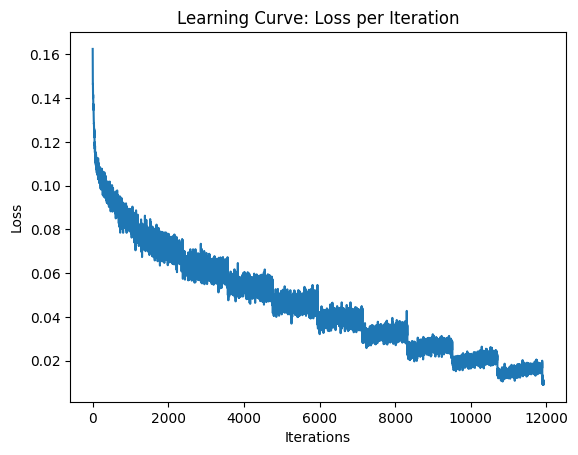

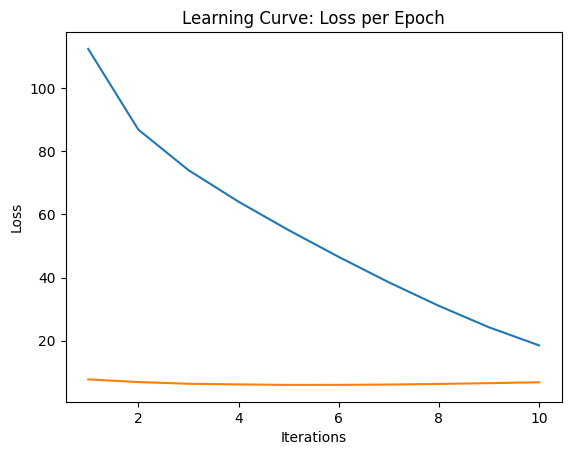

In [91]:
# Model with 8 heads, 6 encoder/decoders
plot_learning_curve(iters, iter_losses, epochs, train_losses, val_losses)

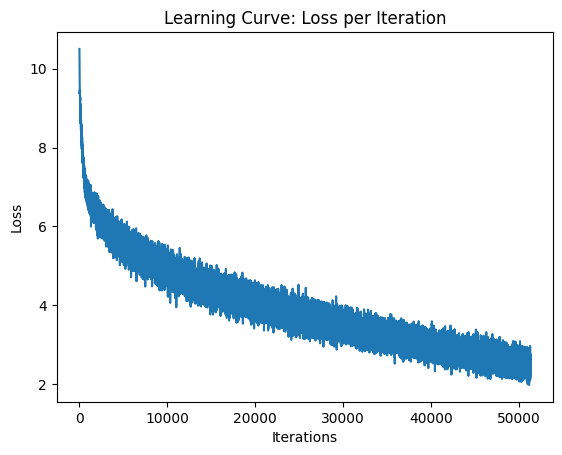

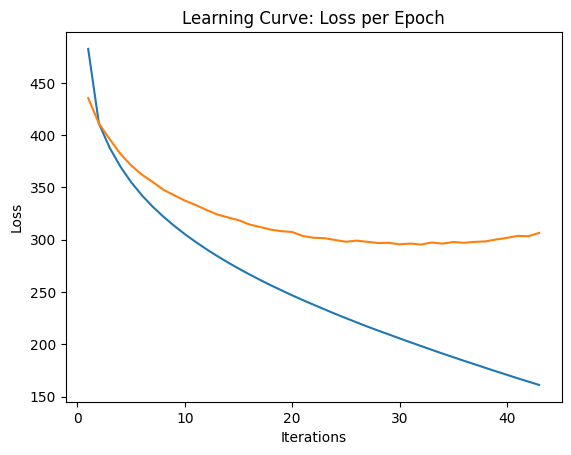

In [63]:
# model with 1024 feedforward, 8 heads, 4 encoders/decoders
plot_learning_curve(iters, iter_losses, epochs, train_losses, val_losses)

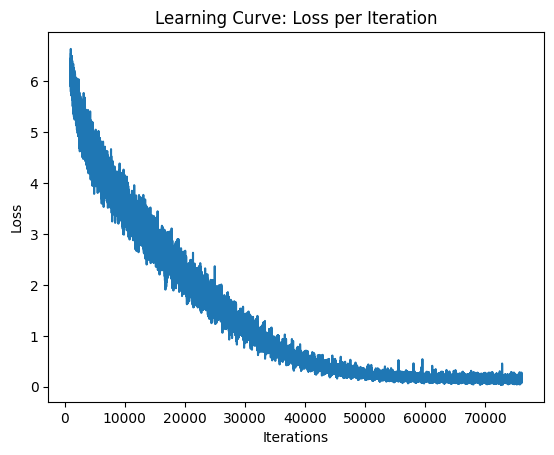

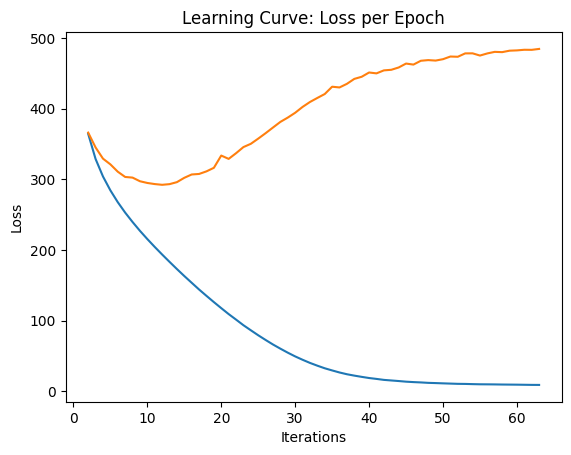

In [75]:
plot_learning_curve(iters[52316:], iter_losses[52316:], epochs[44:], train_losses[44:], val_losses[44:])

In [73]:
loader = torch.utils.data.DataLoader(train_data, batch_size=64, collate_fn=data_collator,\
                                         shuffle=True)

In [74]:
len(loader)

1189

In [ ]:
model = TransformerModel(vocab_size=vocab_size)
model.load_state_dict(torch.load\
                      ('/content/gdrive/My Drive/Transformerckpt-5.pk'))

<All keys matched successfully>

In [ ]:
len(loader)

In [ ]:
# check output of the model
model.eval()
g1 = glove_embed(inp_lst[3][0]).to(device)
g2 = glove_embed([[50256]]*16).to(device)
model.to(device)
summary = model(g1, g2)

In [ ]:
tokenizer.convert_ids_to_tokens(inp_lst[4][0][0])

In [ ]:
summary.size()

torch.Size([16, 1, 50257])

In [ ]:
get_summary(summary[8])

['Ġto']


In [ ]:
tokenizer.decode(summary)

In [ ]:
test_data = test_data.map(preprocess_function, batched = True)

In [ ]:
test_data[:5]['input_ids']

**** DONT RUN ANYTHING UNDER THIS --------------------------------------------------------------** **